# imports of functions

In [5]:
import argparse
import os
import sys
import pickle
import subprocess
import icelakes
from icelakes.utilities import encedc, decedc, get_size
from icelakes.nsidc import download_granule, edc
from icelakes.detection import read_atl03, detect_lakes, melt_lake

parser = argparse.ArgumentParser(description='Test script to print some stats for a given ICESat-2 ATL03 granule.')
parser.add_argument('--granule', type=str, default='ATL03_20220714010847_03381603_006_02.h5',
                    help='The producer_id of the input ATL03 granule')
parser.add_argument('--polygon', type=str, default='geojsons/jakobshavn_small.geojson',
                    help='The file path of a geojson file for spatial subsetting')
parser.add_argument('--is2_data_dir', type=str, default='IS2data',
                    help='The directory into which to download ICESat-2 granules')
parser.add_argument('--download_gtxs', type=str, default='all',
                    help='String value or list of gtx names to download, also accepts "all"')
parser.add_argument('--out_data_dir', type=str, default='detection_out_data',
                    help='The directory to which to write the output data')
parser.add_argument('--out_plot_dir', type=str, default='detection_out_plot',
                    help='The directory to which to write the output plots')
parser.add_argument('--out_stat_dir', type=str, default='detection_out_stat',
                    help='The directory to which to write the granule stats')
# args = parser.parse_args()
args = parser.parse_args("")

In [6]:
# # try to figure out where the script is being executed (just to show those maps at conferences, etc...)
# try:
#     with open('location-wrapper.sh', 'rb') as file: script = file.read()
#     geoip_out = subprocess.run(script, shell=True, capture_output=True)
#     compute_latlon = str(geoip_out.stdout)[str(geoip_out.stdout).find('<x><y><z>')+9 : str(geoip_out.stdout).find('<z><y><x>')]
#     print('\nThis job is running at the following lat/lon location:%s\n' % compute_latlon)
# except:
#     compute_latlon='0.0,0.0'
#     print('\nUnable to determine compute location for this script.\n')

# # shuffling files around for HTCondor
# for thispath in (args.is2_data_dir, args.out_data_dir, args.out_plot_dir):
#     if not os.path.exists(thispath): os.makedirs(thispath)

# # download the specified ICESat-2 data from NSIDC
# input_filename, request_status_code = download_granule(args.granule, args.download_gtxs, args.polygon, args.is2_data_dir, 
#                                              decedc(edc().u), decedc(edc().p))

# # perform a bunch of checks to make sure everything went alright with the nsidc api
# print('Request status code:', request_status_code, request_status_code==200)
# if request_status_code != 200:
#     print('NSIDC API request failed.')
#     sys.exit(127)
# if request_status_code==200:
#     with open('success.txt', 'w') as f: print('we got some sweet data', file=f)
#     if input_filename == 'none': 
#         print('granule seems to be empty. nothing more to do here.') 
#         sys.exit(69)
# if os.path.exists(input_filename):
#     if os.path.getsize(input_filename) < 31457280:# 30 MB
#         print('granule seems to be empty. nothing more to do here.') 
#         sys.exit(69)


In [7]:
input_filename = 'IS2data/processed_ATL03_20220714010847_03381603_006_02.h5'
gtx_list, ancillary = read_atl03(input_filename, gtxs_to_read='none')

  reading in IS2data/processed_ATL03_20220714010847_03381603_006_02.h5
  reading in beam:  --> done.


  reading in IS2data/processed_ATL03_20220714010847_03381603_006_02.h5
  reading in beam: gt1l  --> done.

-----------------------------------------------------------------------------

PROCESSING GROUND TRACK: gt1l (weak)
---> finding flat surfaces in photon data (26 / 685 were flat)
---> removing afterpulses, calculating photon densities & looking for second density peaks below the surface
(16 / 685 pass lake quality test)
---> merging major frame segments that possibly represent lakes iteratively
   --> iteration   0, number of lakes:   16
   --> iteration   1, number of lakes:    8
   --> iteration   2, number of lakes:    4
   --> iteration   3, number of lakes:    3
   --> iteration   4, number of lakes:    2
---> checking lake edges and extending them if the surface elevation matches
extending lake  0:<> 1: 
---> calculating remaining photon densities
---> removing afterpulses, calculating photon densities & looking for second density peaks below the surface
(17 / 685 pass lake 

NameError: name 'compute_latlon' is not defined

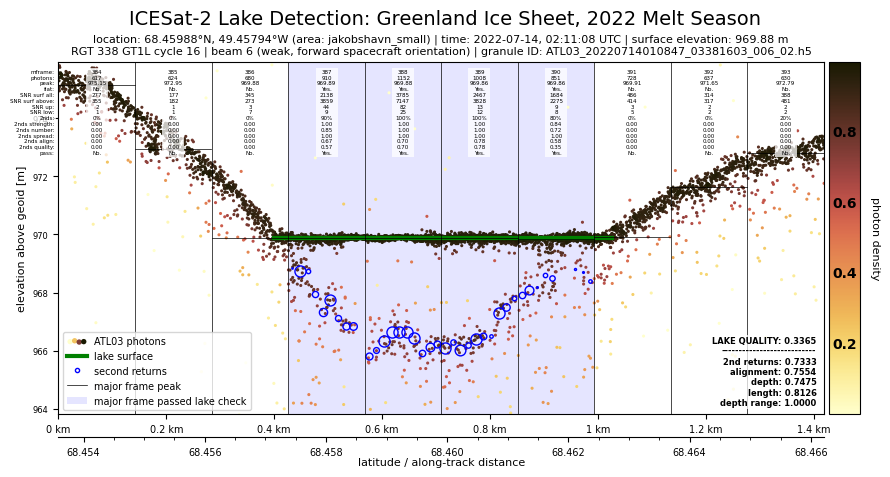

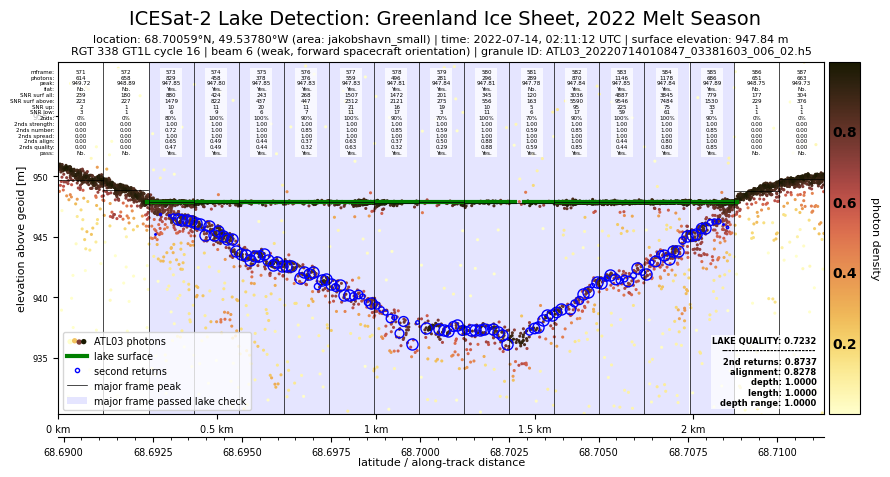

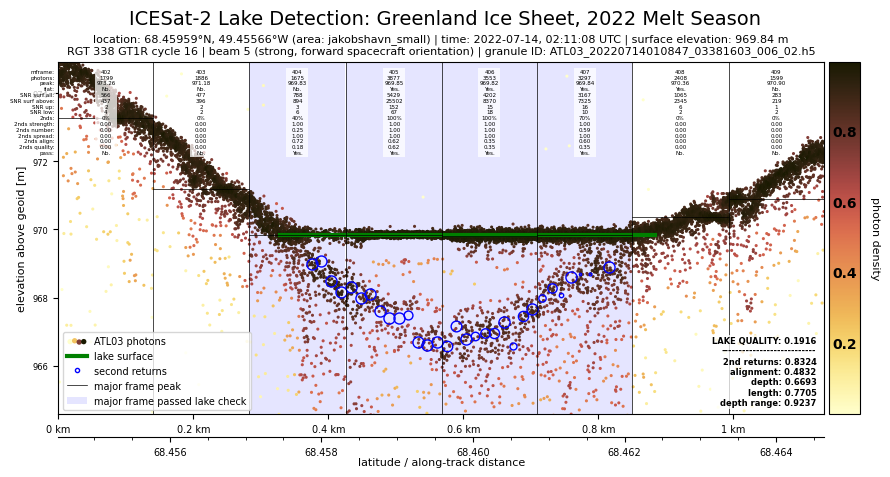

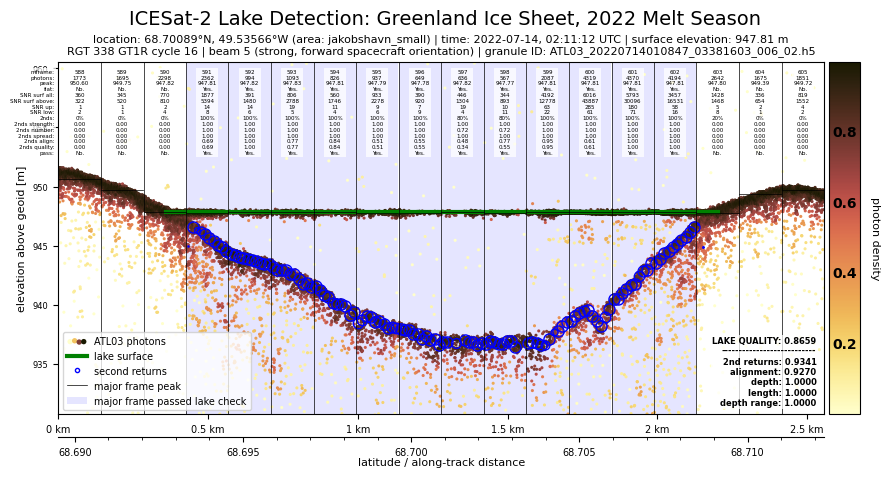

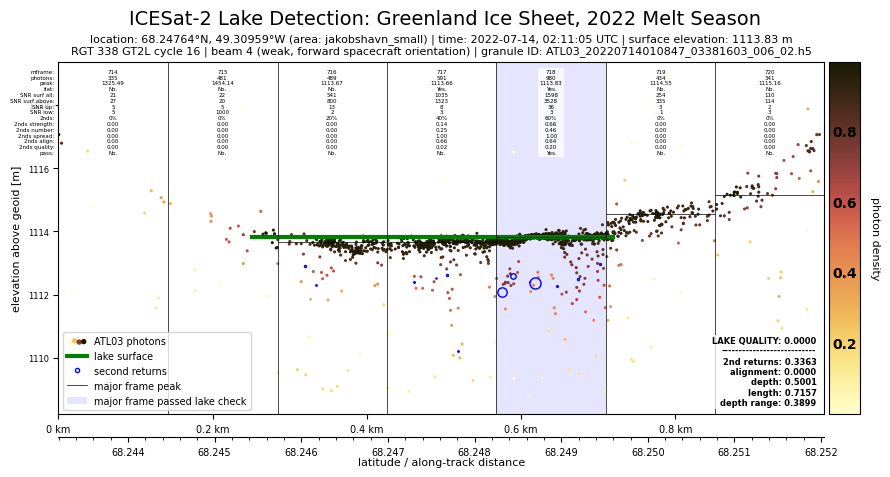

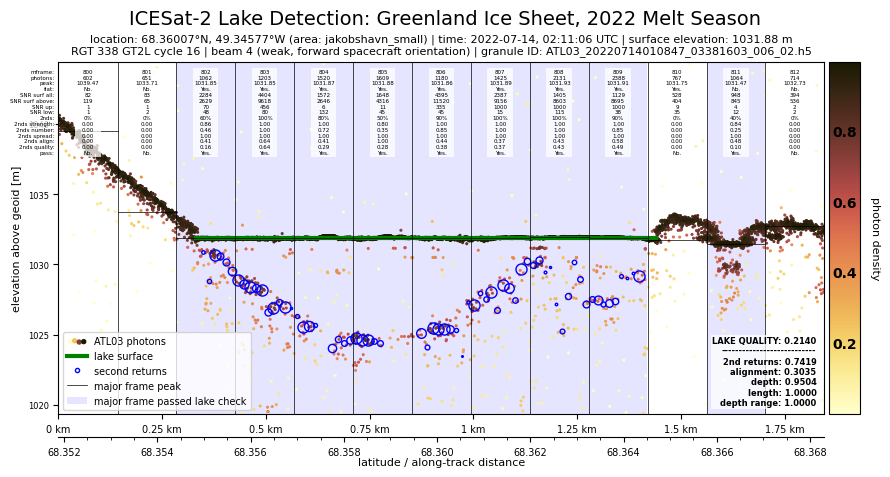

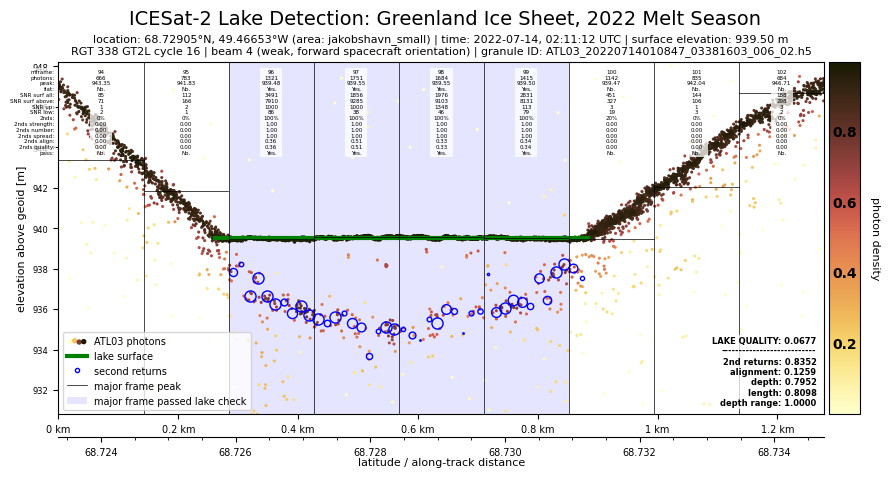

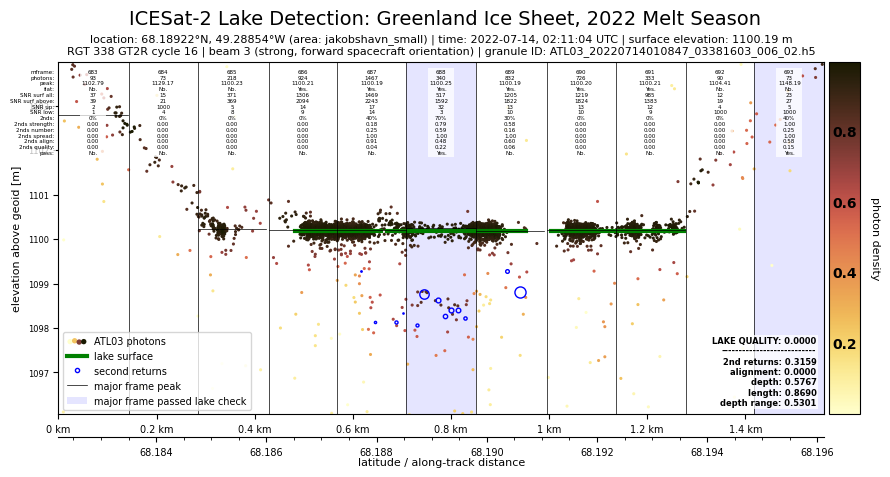

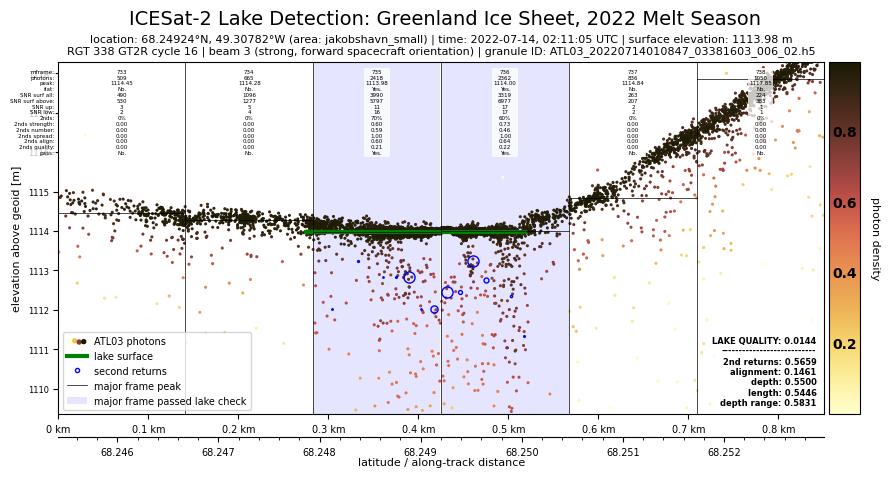

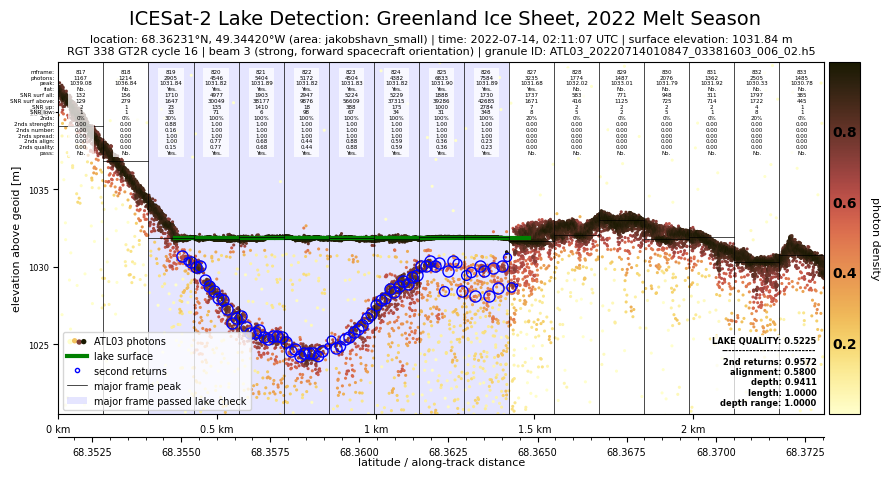

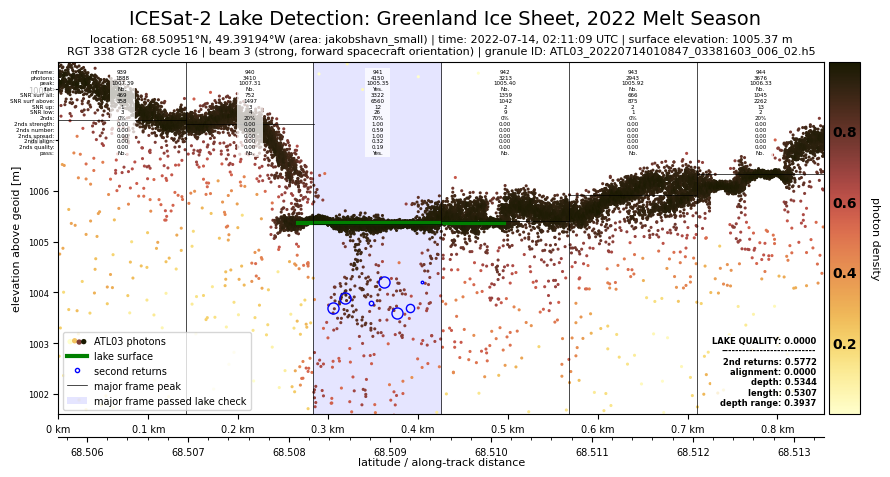

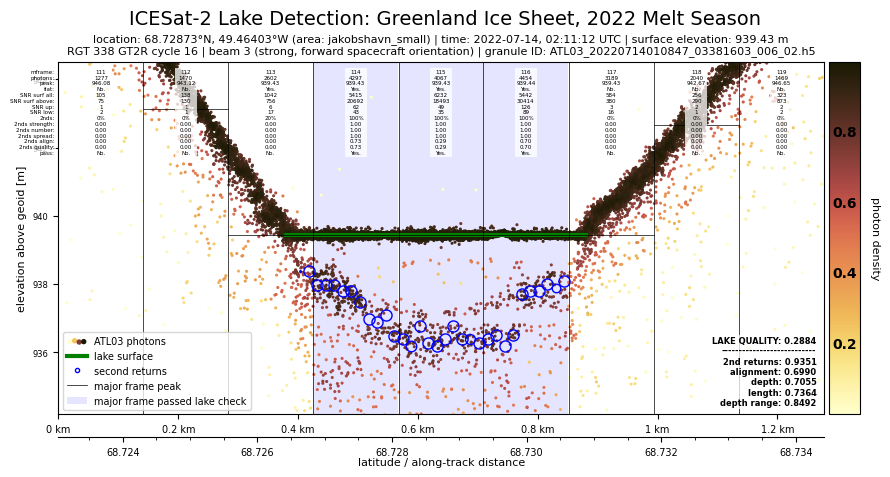

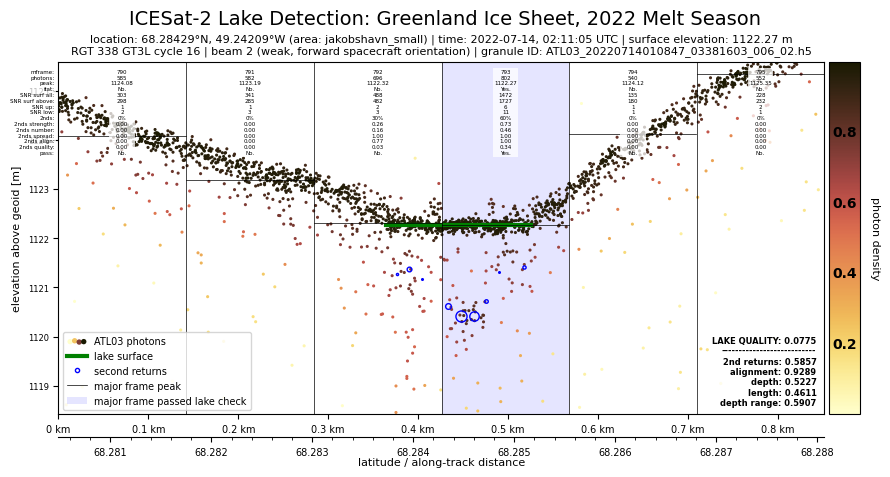

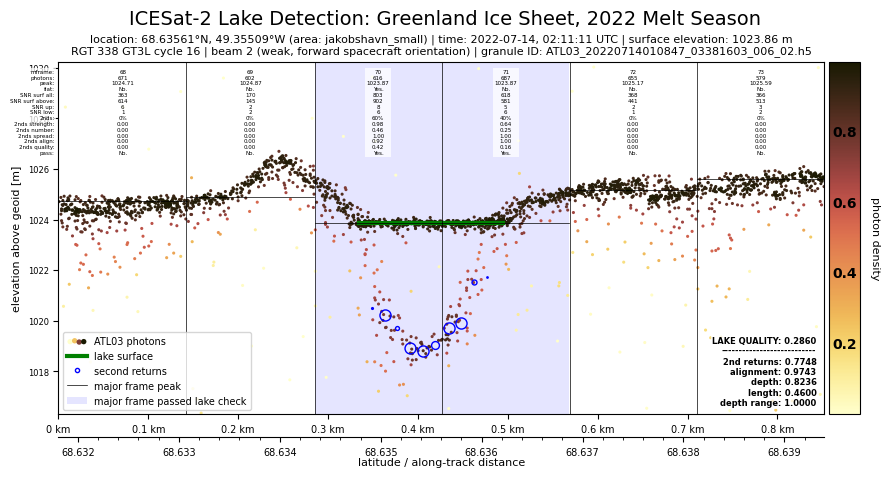

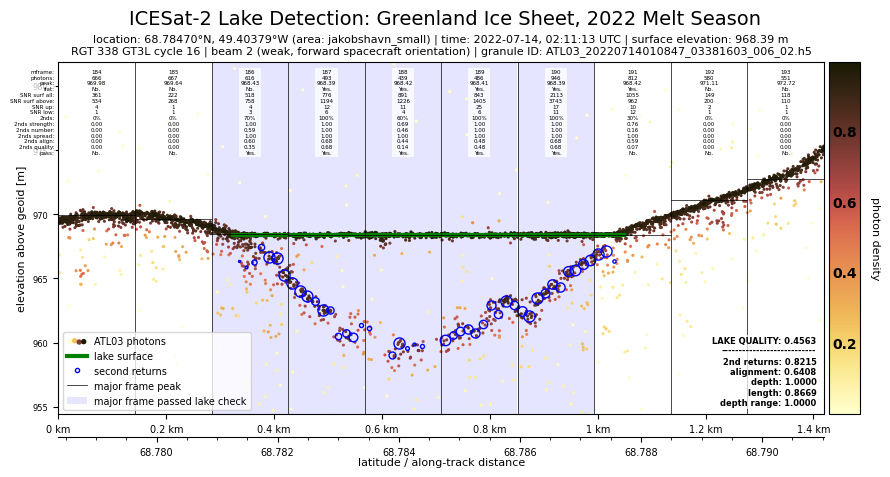

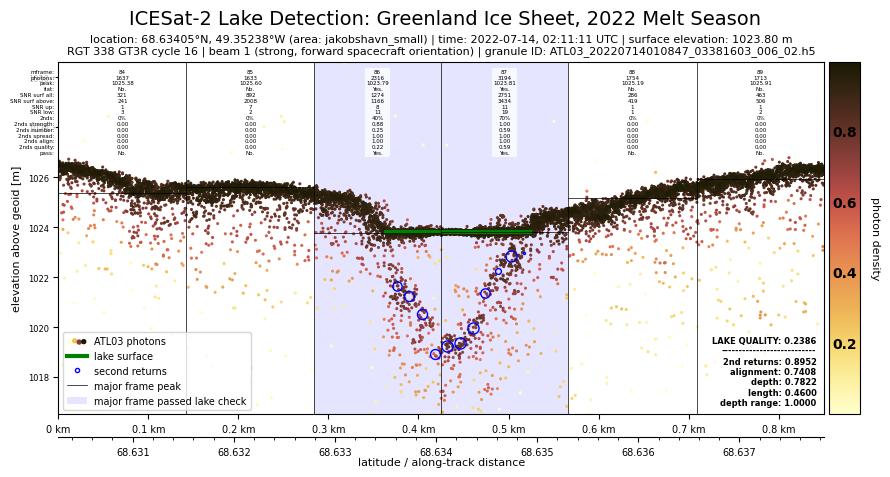

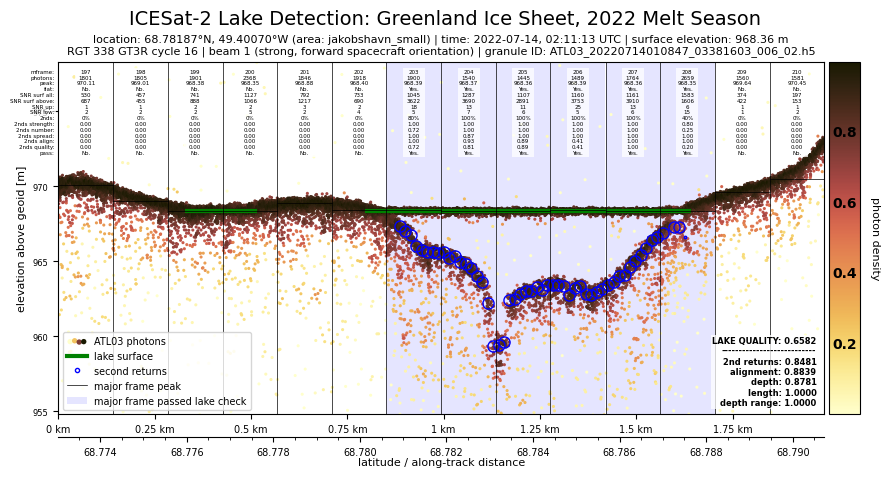

In [8]:
# detect melt lakes
lake_list = []
granule_stats = [0,0,0,0]

for gtx in gtx_list:
# for gtx in ['gt2r']:
    lakes_found, gtx_stats = detect_lakes(input_filename, gtx, args.polygon, verbose=False)
    for i in range(len(granule_stats)): granule_stats[i] += gtx_stats[i]
    lake_list += lakes_found

if granule_stats[0] > 0:
    with open('success.txt', 'w') as f: print('we got some data from NSIDC!!', file=f)
    print('Sucessfully retrieved data from NSIDC!!')
    
# print stats for granule
print('\nGRANULE STATS (length total, length lakes, photons total, photons lakes):%.3f,%.3f,%i,%i\n' % tuple(granule_stats))

# save plots and lake data dictionaries
for lake in lake_list:
    filename_base = 'lake_%05i_%s_%s_%s_%s_%s' % ((1.0-lake.detection_quality)*10000, lake.ice_sheet, lake.melt_season, 
                                                  lake.polygon_name, lake.granule_id[:-3], lake.gtx)
    # plot each lake and save to image
    fig = lake.plot_detected(min_width=0.0, min_depth=0.0, closefig=False)
    figname = args.out_plot_dir + '/%s.jpg' % filename_base
    if fig is not None: fig.savefig(figname, dpi=300, bbox_inches='tight', pad_inches=0)
    
    # export each lake to h5 and pickle
    try:
        h5name = args.out_data_dir + '/%s.h5' % filename_base
        datafile = lake.write_to_hdf5(h5name)
        print('Wrote data file: %s, %s' % (datafile, get_size(datafile)))
    except:
        print('Could not write hdf5 file.')
        try:
            pklname = args.out_data_dir + '/%s.pkl' % filename_base
            with open(pklname, 'wb') as f: pickle.dump(vars(lake), f)
            print('Wrote data file: %s, %s' % (pklname, get_size(pklname)))
        except:
            print('Could not write pickle file.')

statsfname = args.out_stat_dir + '/stats_%s_%s.csv' % (args.polygon[args.polygon.rfind('/')+1:].replace('.geojson',''), args.granule[:-4])
with open(statsfname, 'w') as f: print('%.3f,%.3f,%i,%i,%s' % tuple(granule_stats+[compute_latlon]), file=f)
    
# clean up the input data
# os.remove(input_filename)

print('\n-------------------------------------------------')
print(  '----------->   Python script done!   <-----------')
print(  '-------------------------------------------------\n')

In [ ]:
%matplotlib widget
import matplotlib.pylab as plt
from cmcrameri import cm as cmc
lk = lake_list[2]
dfp = lk.photon_data
dfs = dfp[~dfp.is_afterpulse]
dfap = dfp[dfp.is_afterpulse]
fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)
ax.scatter(dfs.xatc, dfs.h-lk.surface_elevation, s=1, c=dfs.snr, cmap=cmc.batlow_r, vmin=0, vmax=1)
ax.scatter(dfap.xatc, dfap.h-lk.surface_elevation, s=1, c=dfap.snr, cmap=cmc.batlow_r, alpha=0.2, vmin=0, vmax=1)
# ax.scatter(dfp.xatc, dfp.h, s=10, c='g')
dfg = dfs.groupby('pulseid').mean()
ax.scatter(dfg.xatc, dfg.sat_ratio.rolling(20,center=True).mean(), s=1, c=dfg.sat_ratio, cmap=cmc.roma_r, alpha=0.2, vmin=0, vmax=1)

In [ ]:
dfs.groupby('pulseid').mean()

In [ ]:
dfp

In [ ]:
from utils import *
from os import listdir, makedirs
from os.path import isfile, join, exists
import os
import rsa

# arguments for future script

In [ ]:
granule = 'ATL03_20210715182907_03381203_005_01.h5'
shapefile = '/shapefiles/jakobshavn_small.shp'
gtxs = 'gt1l'

# download the specified granule via NSIDC
...and subset to the provided shapefile / only pull the variables needed

In [ ]:
datadir = '/IS2data'

In [ ]:
# %%capture celloutput 
download_granule_nsidc(granule, gtxs, shapefile, datadir, decedc(edc().u), decedc(edc().p))

# read in the .h5 subsetted granule file

In [ ]:
filelist = [datadir[1:]+'/'+f for f in listdir(datadir[1:]) if isfile(join(datadir[1:], f)) & ('.h5' in f)]
print('\nNumber of processed ATL03 granules to read in: ' + str(len(filelist)))
    
photon_data, bckgrd_data, ancillary = read_atl03(filelist[0], geoid_h=True)
print_granule_stats(photon_data, bckgrd_data, ancillary, outfile='stats.txt')